# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

## Подготовка

    Проект выполнен с BERT!

In [2]:
import gc
import numpy as np
import pandas as pd
import evaluate
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
import transformers
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, get_scheduler, BertForSequenceClassification, BertTokenizer, TextClassificationPipeline

ModuleNotFoundError: No module named 'evaluate'

In [3]:
print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

NameError: name 'transformers' is not defined

    Transformers version: 4.51.3
    PyTorch version: 2.7.0+cu128
    CUDA available: True

In [4]:
RANDOM_STATE = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NameError: name 'torch' is not defined

    Импорт библиотек и настройка окружения

In [ ]:
data = pd.read_csv("YOUR_DATA")

In [8]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [9]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


    Всего у нас 159 тысяч текстов 16 тысяч из которых токсичные комментарии, в целом этого более чем хватит

In [11]:
data = data[['text', 'toxic']]
data.columns = ['text', 'labels']

    Поделил колонки для удобства на две текст и лейбл

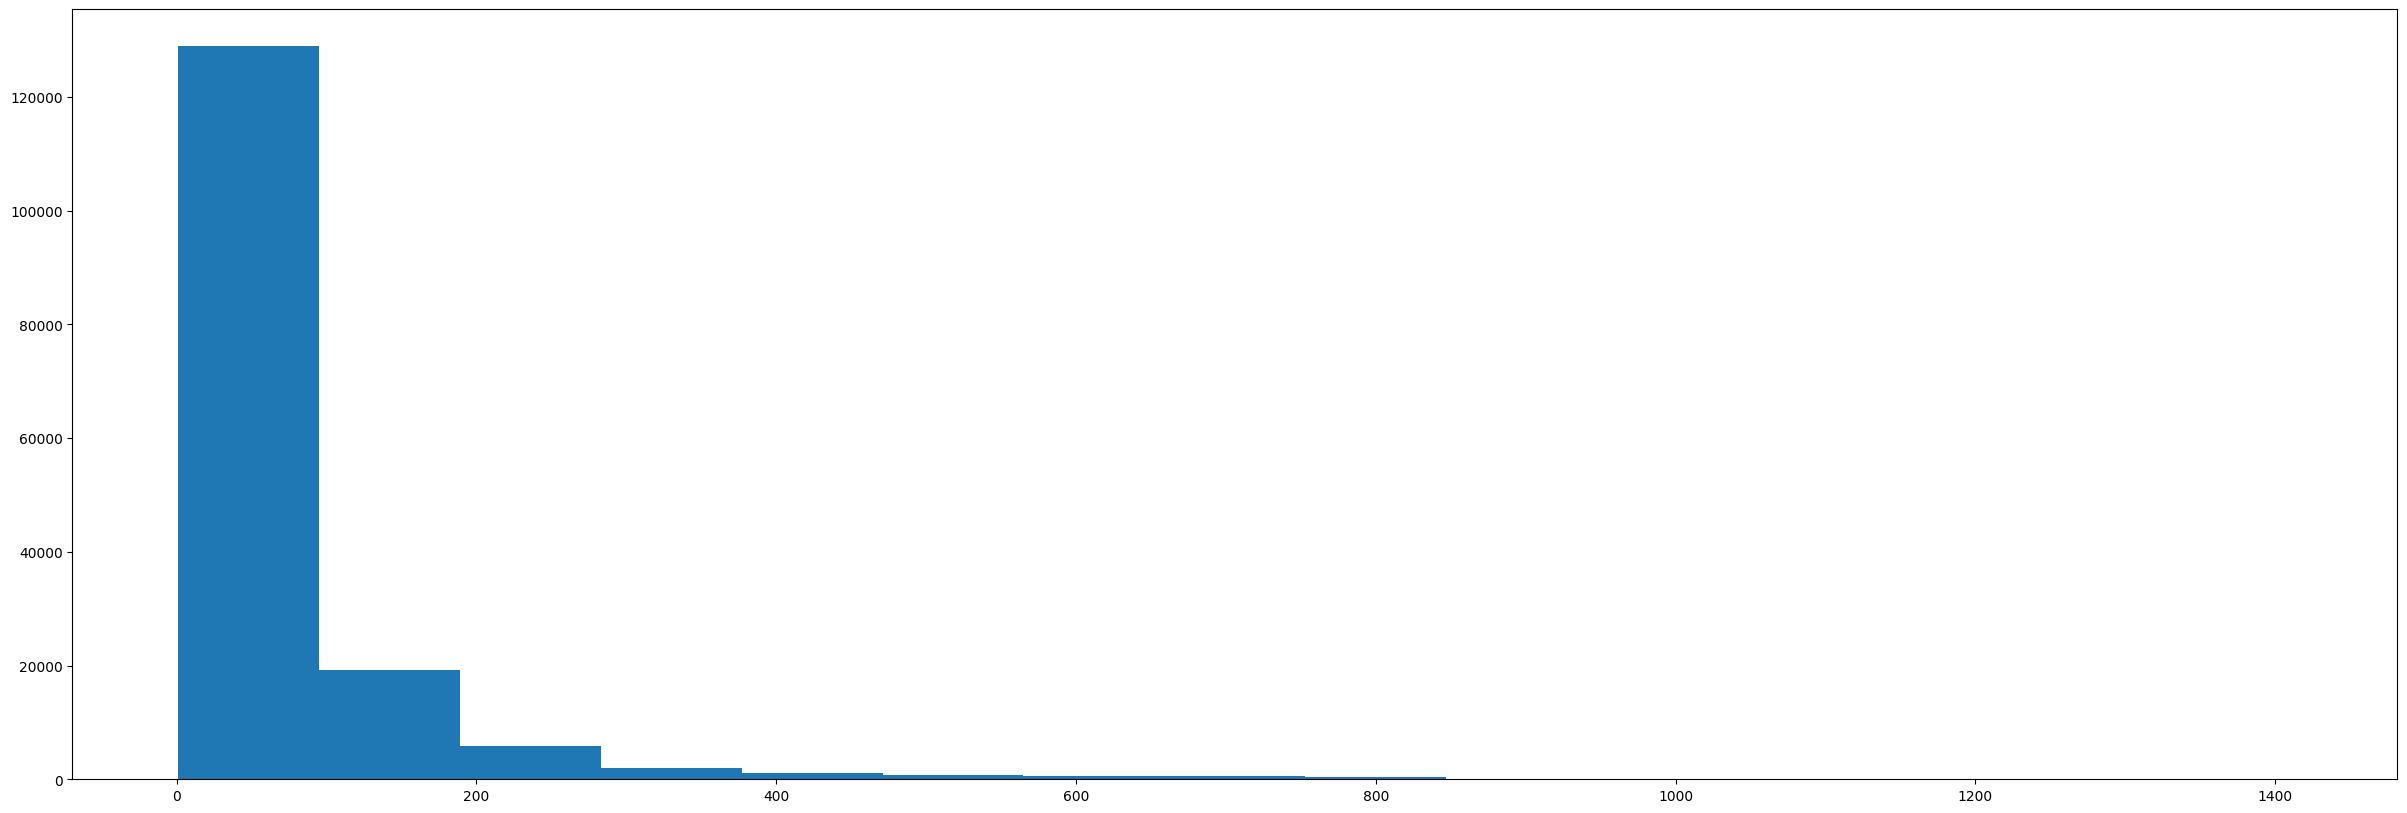

In [10]:
data['text'].apply(lambda x: len(x.split())).hist(figsize=(30, 10), bins=15, grid=False)

    Большинство текстов длинной около 300 символом, для удобства буду использовать вектор длинной 256

In [11]:
data = data.sample(frac=1).reset_index(drop=True)
train = data[:int(len(data)*0.8)]
test =  data[int(len(data)*0.8):]

In [12]:
len(train), len(test)

In [13]:
print(len(train['labels'].value_counts()))

In [14]:
print(len(test['labels'].value_counts()))

In [15]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

    Данные поделены на тренировочную и тестовую выборки, на тестовую выделено 20 процентов даннх, в обоих выборках есть по два лейбла

## Обучение

In [16]:
model_name = "JungleLee/bert-toxic-comment-classification"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

    В обучении буду использовать модель BERT JungleLee/bert-toxic-comment-classification

In [17]:
torch.cuda.empty_cache()
gc.collect()

In [18]:
model.to(device)

    Перенос модели на гпу

In [19]:
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

In [20]:
dataset = dataset.map(lambda x: tokenizer(x['text'], truncation = True, max_length=255, padding='max_length'), batched=True)

In [21]:
pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']  
dataset = dataset.remove_columns(list(set(list(dataset['train'].features.keys())) - set(pytorch_style_columns)))

Предоставил BERT'у специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают позитивную эмоциональную окраску, единицы - негативную.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.
- **token_type_ids** Указывает является ли последовательность «контекстом», используемый для вопроса (все токены 0) или «вопросому» (все токены 1).

In [22]:
dataset

In [23]:
dataset.set_format(type='torch', columns=pytorch_style_columns, device='cuda') # убрать здесь

In [ ]:
# 3 батча обучалось на 4070 на 12 гб под забивку памяти +- 11.9 гб
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=3)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=1)

In [25]:
len(train_dataloader)

    Перевел в формат пайторча. Загрузил на гпу, если есть cuda, иначе девайс стоит убрать из аргумента  

In [26]:
optimizer = AdamW(model.parameters(), lr=2e-6)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
# будем линейно увеличивать первые 200 шагов
lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=2000,
    num_training_steps=num_training_steps
)

In [27]:
gc.collect()
torch.cuda.empty_cache()

In [28]:
# лучший f1, по нему будем сохранять
best_f1 = 0.
# средний loss
avg_loss = deque([], maxlen=50)

# проходимся по всем эпохам
for epoch in range(num_epochs):
    # отображаем номера эпох
    print(40*'-', '\nepoch', epoch+1)
    # переводим в режим тренировки
    model.train()
    # итерируемся по треин части
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            # переводим в режим тренировки
            model.train()
            # переносим батч на гпу, где и модель
            batch = {k: v.to(device) for k, v in batch.items()}
            # получаем прогнозы
            outputs = model(**batch)
            # получаем лосс встроенный вместе с моделью (кросс-энтропия)
            loss = outputs.loss
            # делаем обратный проход
            loss.backward()
            # шаг по градиенту
            optimizer.step()
            # шаг по скорости
            lr_scheduler.step()
            # шаг по оптимизатору
            optimizer.zero_grad()
            # фиксируем потери на треин
            avg_loss.append(loss.item())
            # добавляем в прогрессбар информацию о среднем лоссе за 50 батчей
            tepoch.set_postfix(loss=np.array(list(avg_loss)).mean())

    losses = []
    # валидируемся в конце эпохи
    print('\nvalidating')
    # загружаем все основные метрики
    f1 = evaluate.load('f1')
    acc = evaluate.load('accuracy')
    precision = evaluate.load('precision')
    recall = evaluate.load('recall')
    with torch.no_grad():
        # переводим в режим валидации
        model.eval()
        # проходимся по всем батчам из теста
        for batch in tqdm(test_dataloader):
            # переносим их на гпу
            batch = {k: v.to(device) for k, v in batch.items()}
            # не обновляя параметры получаем прогнозы
            with torch.no_grad():
                outputs = model(**batch)
            # получаем сразу логиты
            logits = outputs.logits
            # находим верный ответ
            predictions = torch.argmax(logits, dim=-1)
            # логируем в метрики по f1
            f1.add_batch(predictions=predictions, references=batch["labels"])
            acc.add_batch(predictions=predictions, references=batch["labels"])
            precision.add_batch(predictions=predictions, references=batch["labels"])
            recall.add_batch(predictions=predictions, references=batch["labels"])
        print('Test metrics:')
        print('Test acc:', acc.compute()['accuracy'])
        print('Test precision:', precision.compute()['precision'])
        print('Test recall:', recall.compute()['recall'])
        f1_score = f1.compute()['f1']  
        print('Test f1:', f1_score, '\n')
        # если текущая f1 лучше максимальной
        if f1_score > best_f1:
            # максмальная становится текущей
            best_f1 = f1_score
            # сохраняем модель
            model.save_pretrained(f"best_model_f1_max={best_f1}_len=255")

    # переводим обратно в режим тренировки для следующей эпохи
    model.train()

    Каждый шаг обучения закомментировал, по итогу обучения модели у нас получились такие метрики:

        Test acc: 0.9754229574060705
        Test precision: 0.8431044109436069
        Test recall: 0.9318111693921629
        Test f1: 0.8852410962919537
    
    Точность у модели очень высокая, метрика f1 равна 0.885, значение удовлетворяет условию задачи

Обучение длилось +- 2.5 часа

In [29]:
# валидируем по тесту
# реальные ответы и предсказания
true = []
preds = []

# переводим модель в режим инференса
model.eval()
# проходимся по батчам теста
for batch in tqdm(test_dataloader):
    # переносим батч на GPU
    batch = {k: v.to(device) for k, v in batch.items()}
    # без обновления параметров находим прогнозы
    with torch.no_grad():
        outputs = model(**batch)
    # получаем логиты
    logits = outputs.logits
    # из логитов прогноз
    predictions = torch.argmax(logits, dim=-1)
    # добавляем пачки ответов и прогнозов в массивы
    true += batch["labels"].detach().cpu().numpy().tolist()
    preds += predictions.detach().cpu().numpy().tolist()

In [30]:
print(classification_report(true, preds))

    Предикты записаны, выведен отчет, класс с позитивными комментариями определяется почти совершенно точно, класс с негативными определяется чуть хуже, но все равно на высоком урвоне

## Выводы

    Задача проекта была создать классификатор комментариев на позитивные и негативные для нового сервиса интернет-магазина «Викишоп», также основное условие, чтобы модель имела f1-score выше 0.75.
    
    Для решения задачи были проделаны следующие шаги:

        -Загрузка, описание и изучение данных
        -Предобработка данных и подготовка
        -Обучение модели
    
    В качестве модели была выбрана модель BERT'а - JungleLee/bert-toxic-comment-classification, метрика f1 равна 0.885, модель успешно справилась с задачей.
    В целом, можно улучшить метрику, для этого нужно побольше данных: пол, возраст, страна проживания людей, которые пишут комментарии.
